# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
reviews = pd.read_csv('all_reviews_2010_to_2024_final.csv',index_col=0)
specs = pd.read_csv('car_specs_2010_to_2024_final.csv',index_col=0)
expert_reviews_prices = pd.read_csv('expert_reviews_with_prices_final.csv',index_col=0)

# Data Preprocessing

## Merging Dataframes

In [3]:
# Merge reviews and specs
df = pd.merge(reviews, specs, on=['Model Full Name', 'Year'], how='inner')

# Merge the result with expert_reviews_prices
df = pd.merge(df, expert_reviews_prices, on=['Model Full Name', 'Year'], how='inner')

df = df.drop(columns=['Car Model'])

redundant_columns = ['Car Brand_y', 'Car Model_y'] 

# Rename columns for clarity before dropping
df = df.rename(columns={'Car Brand_x': 'Car Brand', 'Car Model_x': 'Car Model'})

df = df.drop(columns=redundant_columns)

In [4]:
df.head()

,Car Brand,Car Model,Year,Review,Rating,Value Rating,Performance Rating,Quality Rating,Comfort Rating,Reliability Rating,...,Combined MPG,Fuel Capacity,Drivetrain,Recommended Fuel,Expert Rating,Expert Review,Lowest MSRP Price,Highest MSRP Price,Lowest KBB Fair Price,Highest KBB Fair Price
0,honda,accord,2010,I've driven my LX over 13 years and the only t...,5.0,NaN,NaN,NaN,NaN,NaN,...,25 mpg,18.5 gallons,FWD,Regular,NaN,2010 Honda Accord Review By KBB Editors Update...,"$22,605","$27,630","$6,803","$6,407"
1,honda,accord,2010,I have this car for 10 years have given me no ...,5.0,5.0,5.0,5.0,5.0,5.0,...,25 mpg,18.5 gallons,FWD,Regular,NaN,2010 Honda Accord Review By KBB Editors Update...,"$22,605","$27,630","$6,803","$6,407"
2,honda,accord,2010,"My 2012 Honda Accord is great, It handles grea...",5.0,4.0,5.0,5.0,5.0,4.0,...,25 mpg,18.5 gallons,FWD,Regular,NaN,2010 Honda Accord Review By KBB Editors Update...,"$22,605","$27,630","$6,803","$6,407"
3,honda,accord,2010,My sibling has this car. I may be a computer p...,5.0,5.0,5.0,5.0,5.0,5.0,...,25 mpg,18.5 gallons,FWD,Regular,NaN,2010 Honda Accord Review By KBB Editors Update...,"$22,605","$27,630","$6,803","$6,407"
4,honda,accord,2010,"I've had this car for 7 years, it's dependable...",5.0,NaN,NaN,NaN,NaN,NaN,...,25 mpg,18.5 gallons,FWD,Regular,NaN,2010 Honda Accord Review By KBB Editors Update...,"$22,605","$27,630","$6,803","$6,407"


In [5]:
df.columns.tolist()

['Car Brand',
 'Car Model',
 'Year',
 'Review',
 'Rating',
 'Value Rating',
 'Performance Rating',
 'Quality Rating',
 'Comfort Rating',
 'Reliability Rating',
 'Styling Rating',
 'Vehicle Class',
 'Model Full Name',
 'Horsepower',
 'Curb Weight',
 'City MPG',
 'Highway MPG',
 'Combined MPG',
 'Fuel Capacity',
 'Drivetrain',
 'Recommended Fuel',
 'Expert Rating',
 'Expert Review',
 'Lowest MSRP Price',
 'Highest MSRP Price',
 'Lowest KBB Fair Price',
 'Highest KBB Fair Price']

## Missing Values and Outliers

In [6]:
# Calculate the percentage of missing values
missing_percent = round((df.isnull().sum() / df.shape[0]) * 100,2)
print(missing_percent)

Car Brand                  0.00
Car Model                  0.00
Year                       0.00
Review                     0.01
Rating                     0.02
Value Rating               6.09
Performance Rating         6.05
Quality Rating             6.37
Comfort Rating             6.41
Reliability Rating         6.71
Styling Rating             6.05
Vehicle Class              0.00
Model Full Name            0.00
Horsepower                 7.38
Curb Weight                9.88
City MPG                   1.30
Highway MPG                1.30
Combined MPG               1.30
Fuel Capacity              4.14
Drivetrain                 0.00
Recommended Fuel           3.21
Expert Rating             49.90
Expert Review              0.00
Lowest MSRP Price          0.00
Highest MSRP Price         0.00
Lowest KBB Fair Price      0.00
Highest KBB Fair Price     0.00
dtype: float64


In [7]:
# Drop Certain Columns:
df = df.drop(columns=['City MPG', 'Highway MPG', 'Expert Review', 'Expert Rating'])

# Include Units in Column Names
df = df.rename(columns={
    'Horsepower': 'Horsepower (hp)',
    'Curb Weight': 'Curb Weight (lbs)',
    'Fuel Capacity': 'Fuel Capacity (gallons)',
    'Lowest MSRP Price': 'Lowest MSRP Price ($)',
    'Highest MSRP Price': 'Highest MSRP Price ($)',
    'Lowest KBB Fair Price': 'Lowest KBB Fair Price ($)',
    'Highest KBB Fair Price': 'Highest KBB Fair Price ($)'
})

# Drop rows with missing 'Review' or 'Rating'
df = df.dropna(subset=['Review', 'Rating'])

# Impute individual ratings with median
rating_cols = ['Value Rating', 'Performance Rating', 'Quality Rating',
               'Comfort Rating', 'Reliability Rating', 'Styling Rating']

# Group-based imputation for ratings using transform
for col in rating_cols:
    df[col] = df.groupby(['Model Full Name', 'Year'])[col].transform(lambda x: x.fillna(x.median()))

# Drop rows with missing values in rating columns
df = df.dropna(subset=rating_cols)

# Function to extract numeric values from strings
def extract_numeric(series):
    return pd.to_numeric(series.str.replace(',', '').str.extract(r'([0-9]+\.?[0-9]*)')[0], errors='coerce')

# List of columns to clean
numeric_cols_with_units = ['Horsepower (hp)', 'Curb Weight (lbs)', 'Fuel Capacity (gallons)',
                           'Combined MPG','Lowest MSRP Price ($)', 'Highest MSRP Price ($)',
                           'Lowest KBB Fair Price ($)', 'Highest KBB Fair Price ($)']

# Clean and convert columns
for col in numeric_cols_with_units:
    df[col] = extract_numeric(df[col])

# Group-based imputation for numerical specifications using transform
for col in numeric_cols_with_units:
    # Fill missing values with the median within each group
    df[col] = df.groupby(['Model Full Name', 'Year'])[col].transform(lambda x: x.fillna(x.median()))
    # If median is still NaN (e.g., all values are missing in the group), fill with overall median
    df[col] = df[col].fillna(df[col].median())

# Impute 'Recommended Fuel' with mode within groups using transform
def fill_mode(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode.iloc[0])
    else:
        # If the mode is empty, fill with the overall mode
        overall_mode = df['Recommended Fuel'].mode()
        return series.fillna(overall_mode.iloc[0] if not overall_mode.empty else 'Unknown')

df['Recommended Fuel'] = df.groupby(['Model Full Name', 'Year'])['Recommended Fuel'].transform(fill_mode)

# Calculate average MSRP and KBB Fair price values
df['Average MSRP Price ($)'] = df.apply(lambda row: (row['Lowest MSRP Price ($)'] + row['Highest MSRP Price ($)']) / 2, axis=1)
df['Average KBB Fair Price ($)'] = df.apply(lambda row: (row['Lowest KBB Fair Price ($)'] + row['Highest KBB Fair Price ($)']) / 2, axis=1)

# Drop the lowest and highest MSRP and KBB Fair price columns
df = df.drop(columns=['Lowest MSRP Price ($)', 'Highest MSRP Price ($)', 'Lowest KBB Fair Price ($)', 'Highest KBB Fair Price ($)'])

df.to_csv('cleaned_car_data.csv')

df.head()

,Car Brand,Car Model,Year,Review,Rating,Value Rating,Performance Rating,Quality Rating,Comfort Rating,Reliability Rating,...,Vehicle Class,Model Full Name,Horsepower (hp),Curb Weight (lbs),Combined MPG,Fuel Capacity (gallons),Drivetrain,Recommended Fuel,Average MSRP Price ($),Average KBB Fair Price ($)
0,honda,accord,2010,I've driven my LX over 13 years and the only t...,5.0,5.0,5.0,5.0,5.0,5.0,...,mid-size,Honda Accord,190.0,3327.0,25.0,18.5,FWD,Regular,25117.5,6605.0
1,honda,accord,2010,I have this car for 10 years have given me no ...,5.0,5.0,5.0,5.0,5.0,5.0,...,mid-size,Honda Accord,190.0,3327.0,25.0,18.5,FWD,Regular,25117.5,6605.0
2,honda,accord,2010,"My 2012 Honda Accord is great, It handles grea...",5.0,4.0,5.0,5.0,5.0,4.0,...,mid-size,Honda Accord,190.0,3327.0,25.0,18.5,FWD,Regular,25117.5,6605.0
3,honda,accord,2010,My sibling has this car. I may be a computer p...,5.0,5.0,5.0,5.0,5.0,5.0,...,mid-size,Honda Accord,190.0,3327.0,25.0,18.5,FWD,Regular,25117.5,6605.0
4,honda,accord,2010,"I've had this car for 7 years, it's dependable...",5.0,5.0,5.0,5.0,5.0,5.0,...,mid-size,Honda Accord,190.0,3327.0,25.0,18.5,FWD,Regular,25117.5,6605.0


In [8]:
# Re-calculate the percentage of missing values
missing_percent = round((df.isnull().sum() / df.shape[0]) * 100,2)
print(missing_percent)

Car Brand                     0.0
Car Model                     0.0
Year                          0.0
Review                        0.0
Rating                        0.0
Value Rating                  0.0
Performance Rating            0.0
Quality Rating                0.0
Comfort Rating                0.0
Reliability Rating            0.0
Styling Rating                0.0
Vehicle Class                 0.0
Model Full Name               0.0
Horsepower (hp)               0.0
Curb Weight (lbs)             0.0
Combined MPG                  0.0
Fuel Capacity (gallons)       0.0
Drivetrain                    0.0
Recommended Fuel              0.0
Average MSRP Price ($)        0.0
Average KBB Fair Price ($)    0.0
dtype: float64


In [9]:
# Checking the data types of the columns
df.dtypes

Car Brand                      object
Car Model                      object
Year                            int64
Review                         object
Rating                        float64
Value Rating                  float64
Performance Rating            float64
Quality Rating                float64
Comfort Rating                float64
Reliability Rating            float64
Styling Rating                float64
Vehicle Class                  object
Model Full Name                object
Horsepower (hp)               float64
Curb Weight (lbs)             float64
Combined MPG                  float64
Fuel Capacity (gallons)       float64
Drivetrain                     object
Recommended Fuel               object
Average MSRP Price ($)        float64
Average KBB Fair Price ($)    float64
dtype: object

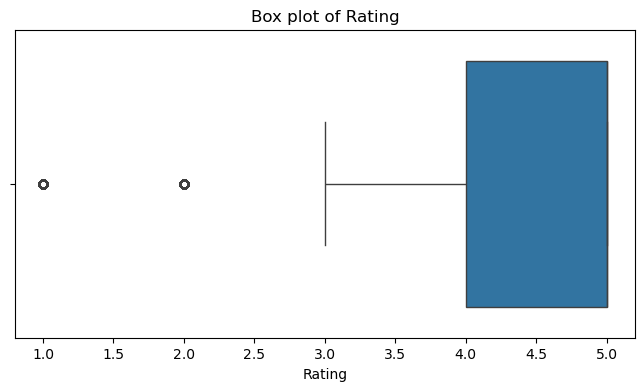

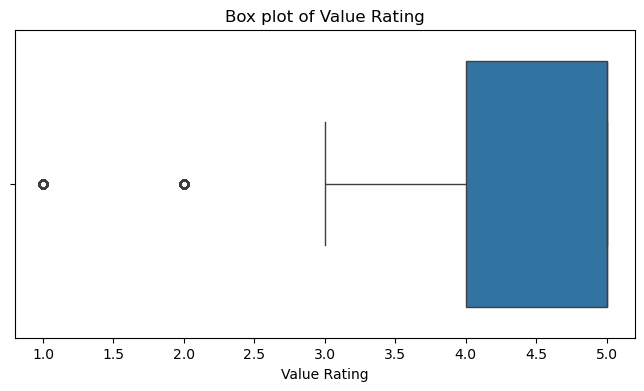

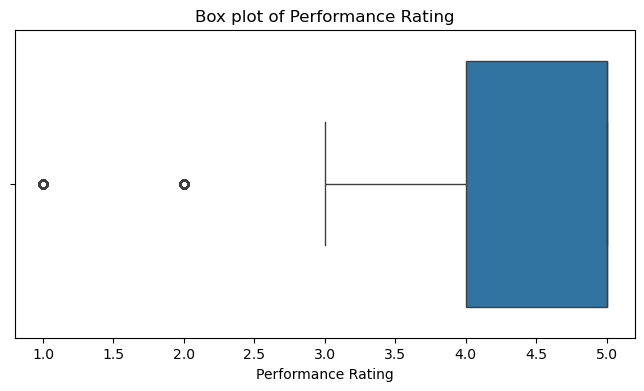

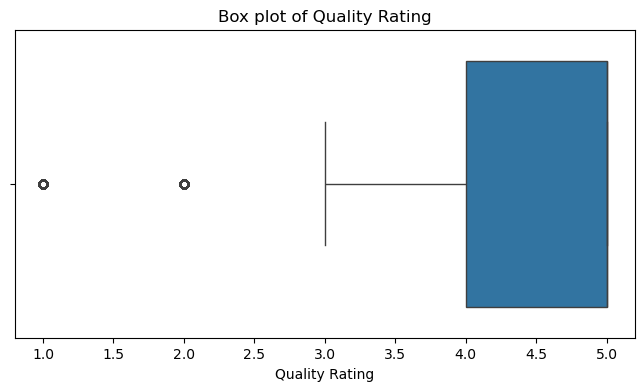

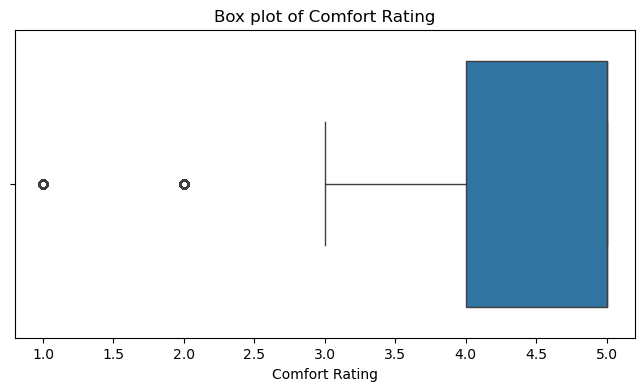

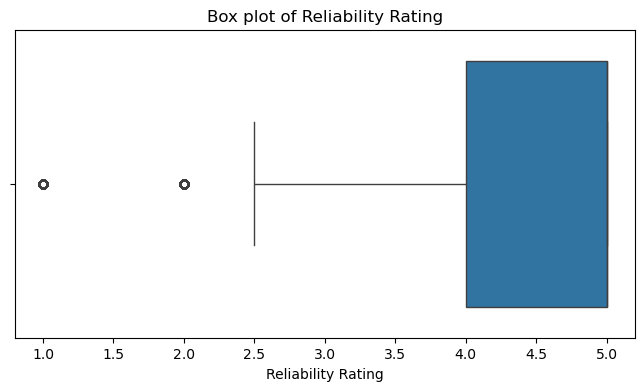

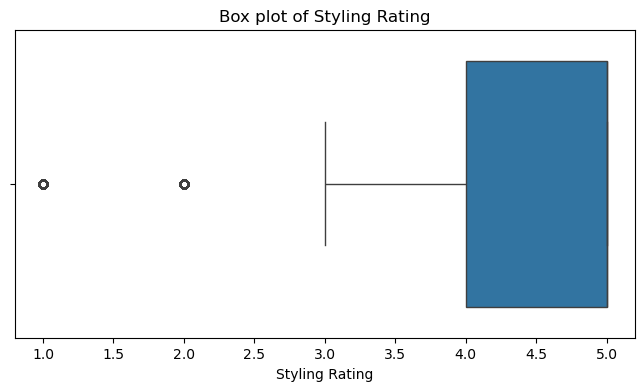

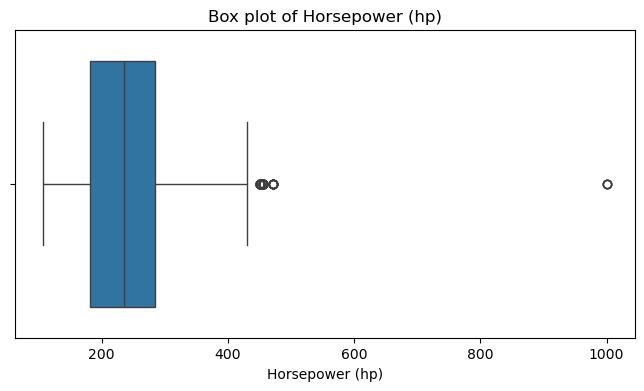

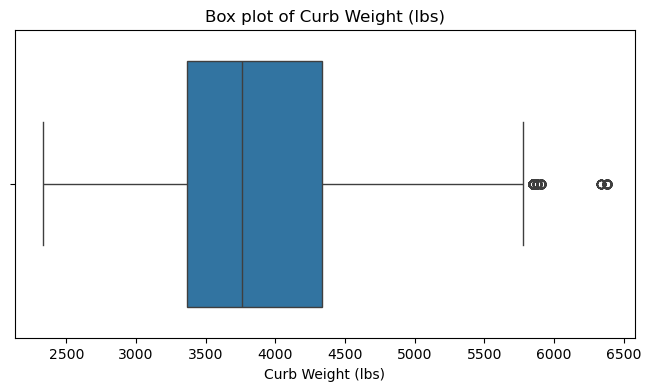

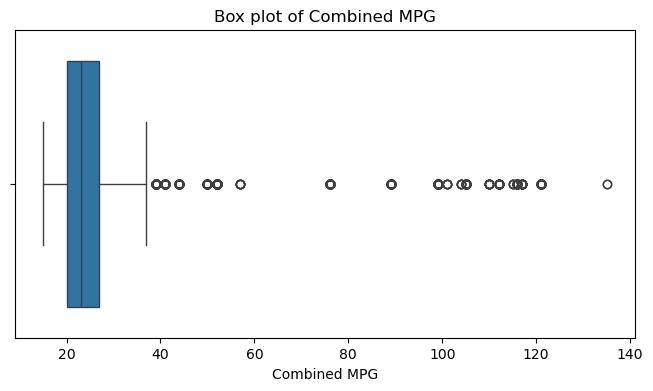

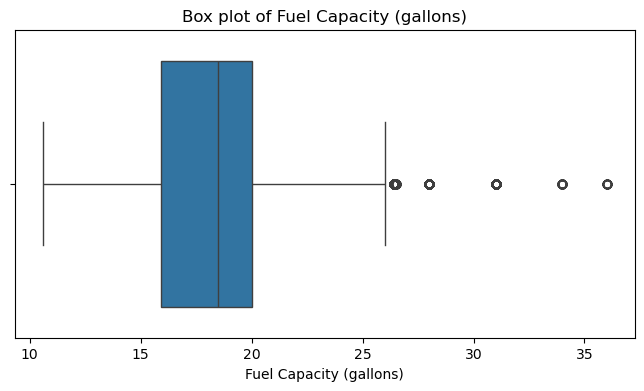

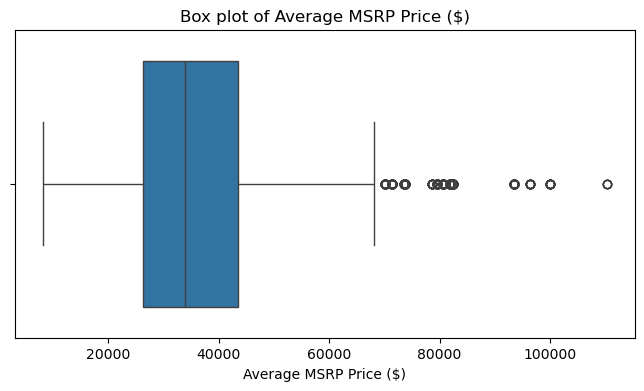

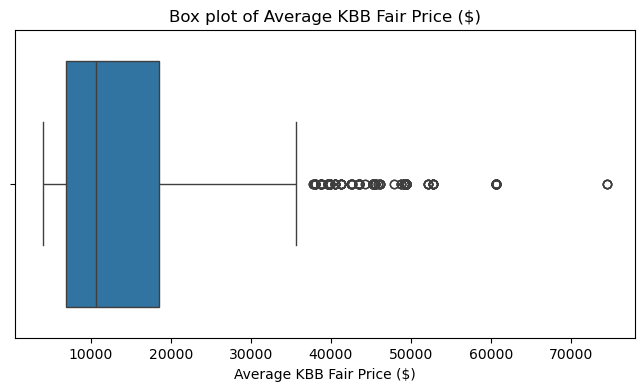

In [10]:
# List of numerical columns to check for outliers
numerical_cols = ['Rating', 'Value Rating', 'Performance Rating', 'Quality Rating', 'Comfort Rating', 
                  'Reliability Rating', 'Styling Rating','Horsepower (hp)', 'Curb Weight (lbs)','Combined MPG', 
                  'Fuel Capacity (gallons)', 'Average MSRP Price ($)','Average KBB Fair Price ($)']

# Box plots to visualize outliers
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

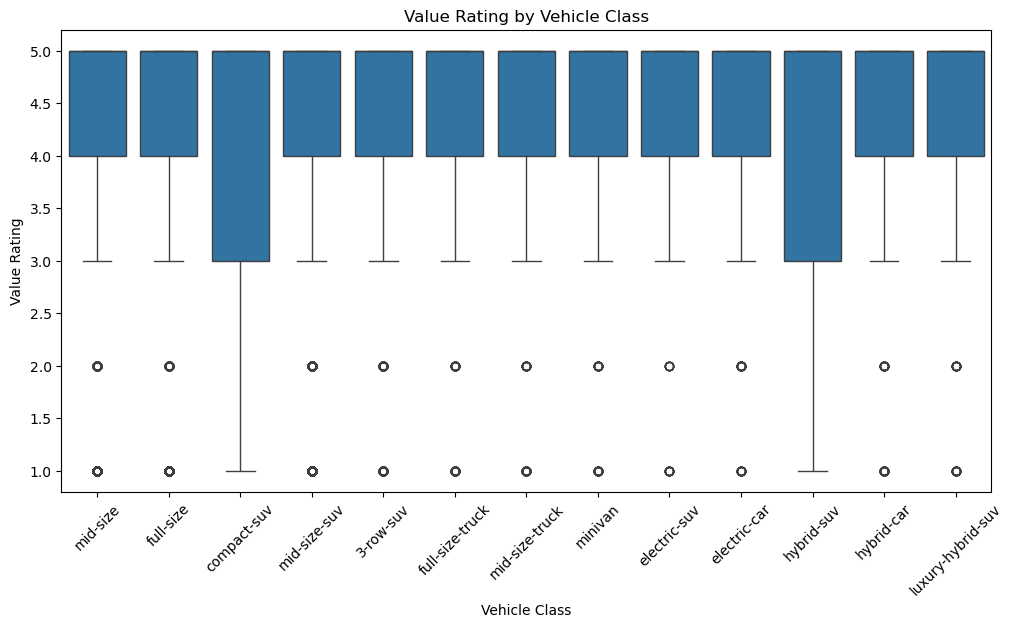

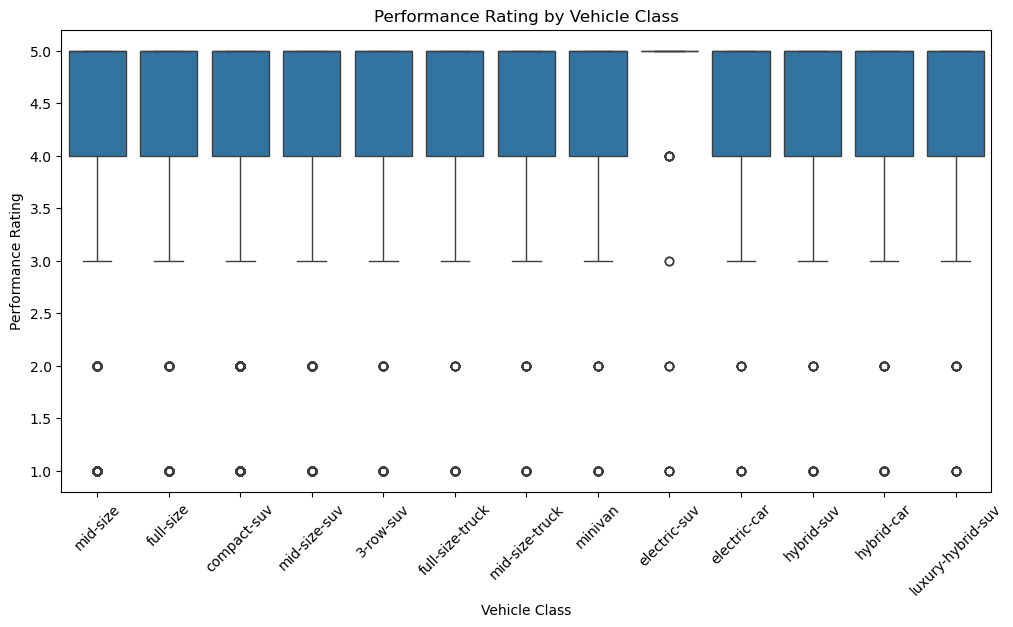

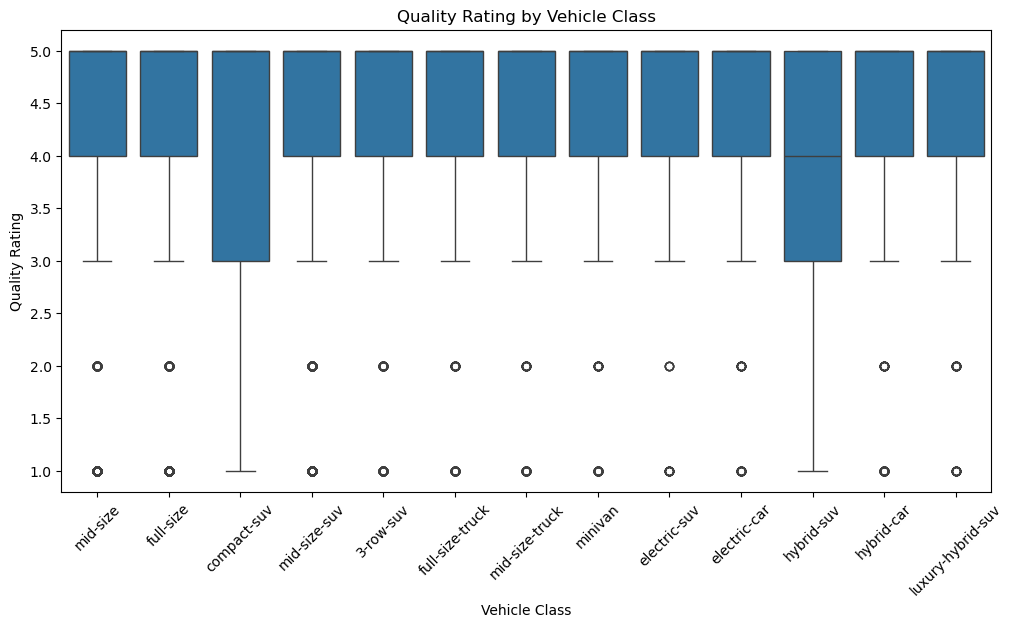

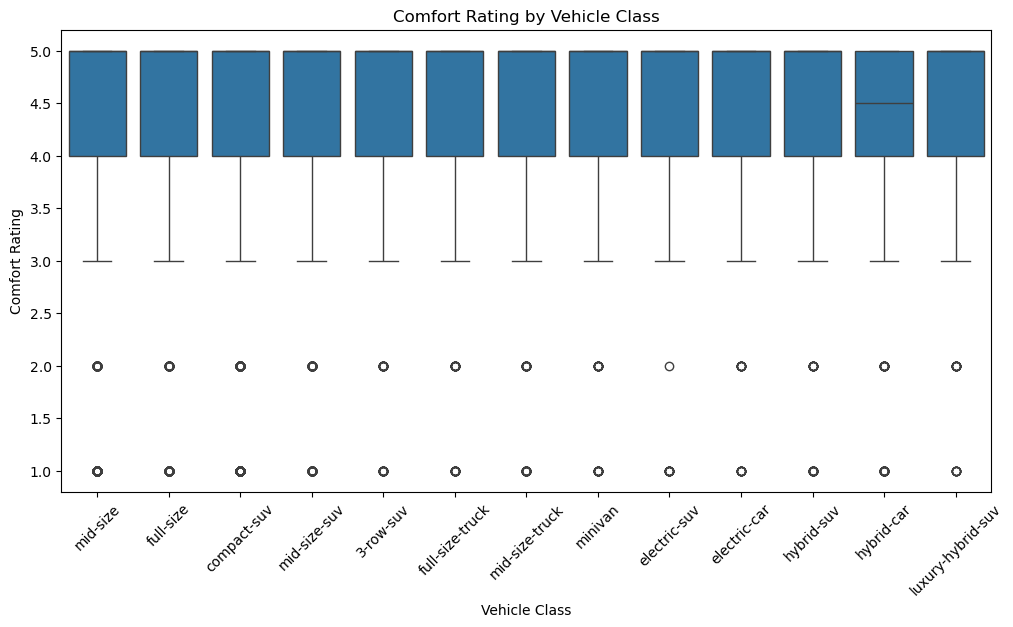

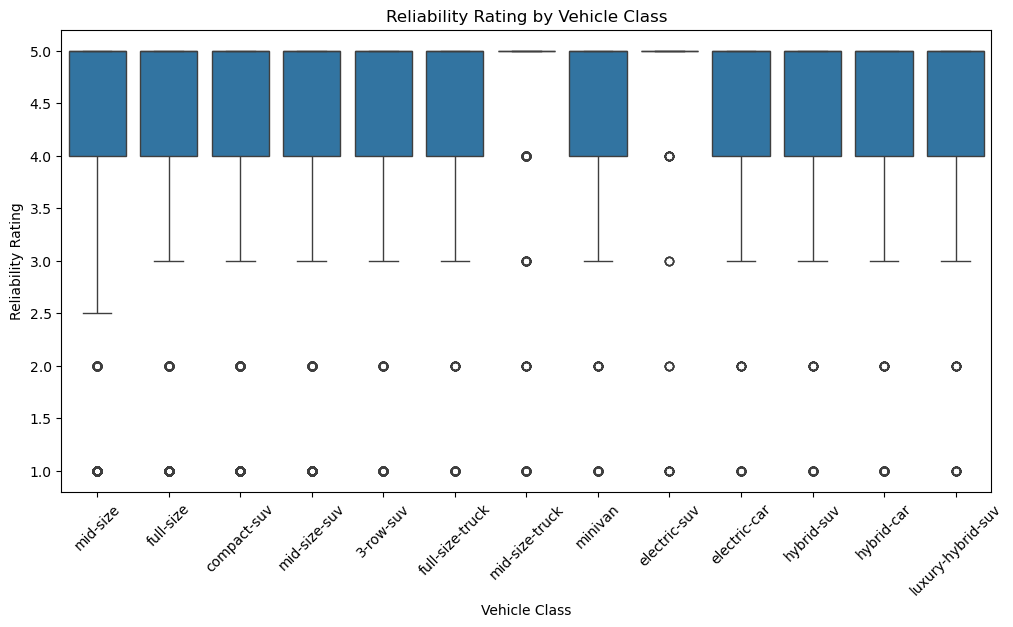

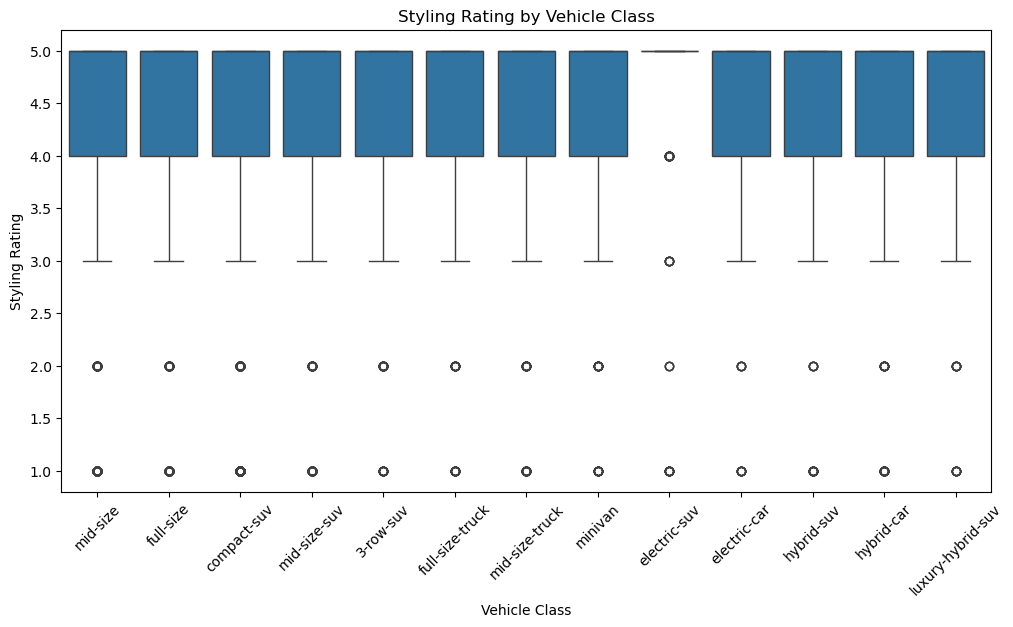

In [11]:
# Box plots to see distribution of ratings across different vehicle classes
for rating_col in rating_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Vehicle Class', y=rating_col, data=df)
    plt.title(f'{rating_col} by Vehicle Class')
    plt.xticks(rotation=45)
    plt.show()

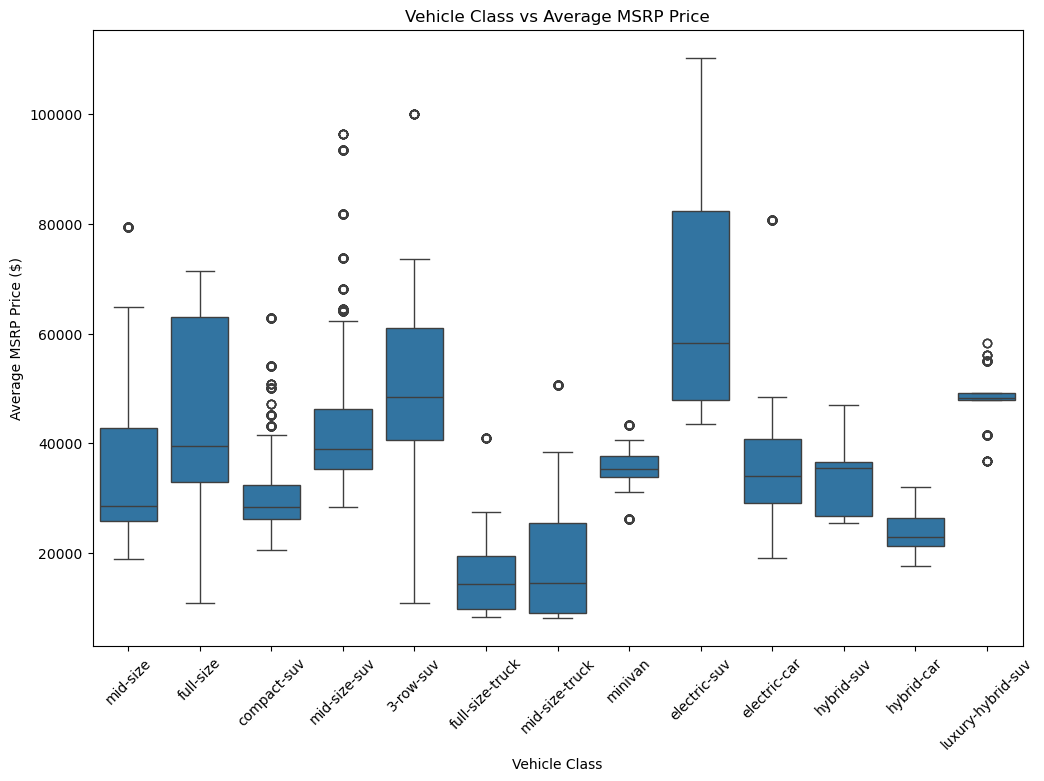

In [12]:
# Boxplot of Vehicle Class vs Average MSRP Price
plt.figure(figsize=(12, 8))
sns.boxplot(x='Vehicle Class', y='Average MSRP Price ($)', data=df)
plt.title('Vehicle Class vs Average MSRP Price')
plt.xticks(rotation=45)
plt.show()

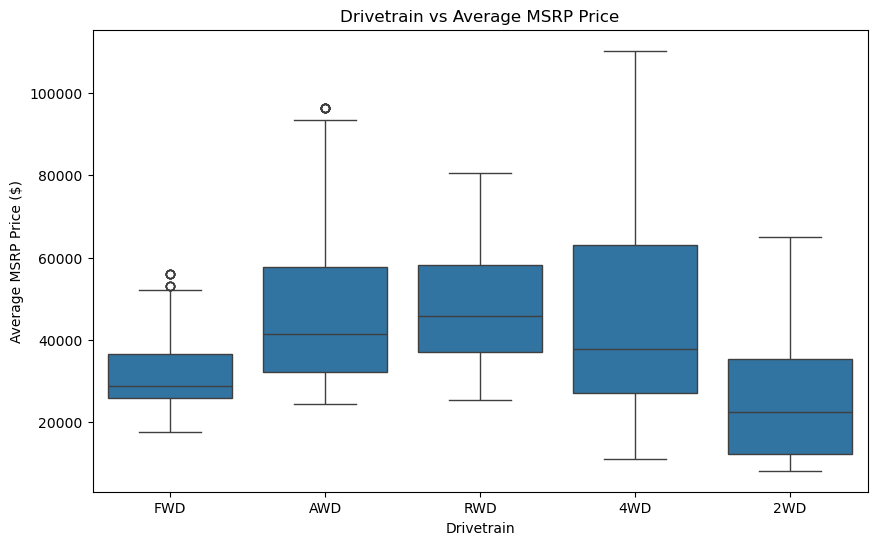

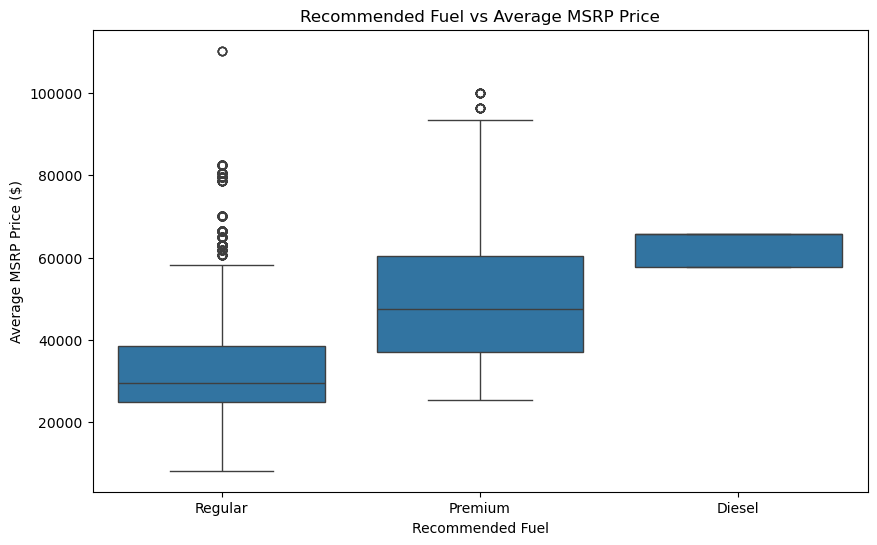

In [13]:
# Boxplot: Drivetrain vs Average MSRP Price
plt.figure(figsize=(10, 6))
sns.boxplot(x='Drivetrain', y='Average MSRP Price ($)', data=df)
plt.title('Drivetrain vs Average MSRP Price')
plt.show()

# Boxplot: Recommended Fuel vs Average MSRP Price
plt.figure(figsize=(10, 6))
sns.boxplot(x='Recommended Fuel', y='Average MSRP Price ($)', data=df)
plt.title('Recommended Fuel vs Average MSRP Price')
plt.show()

# EDA

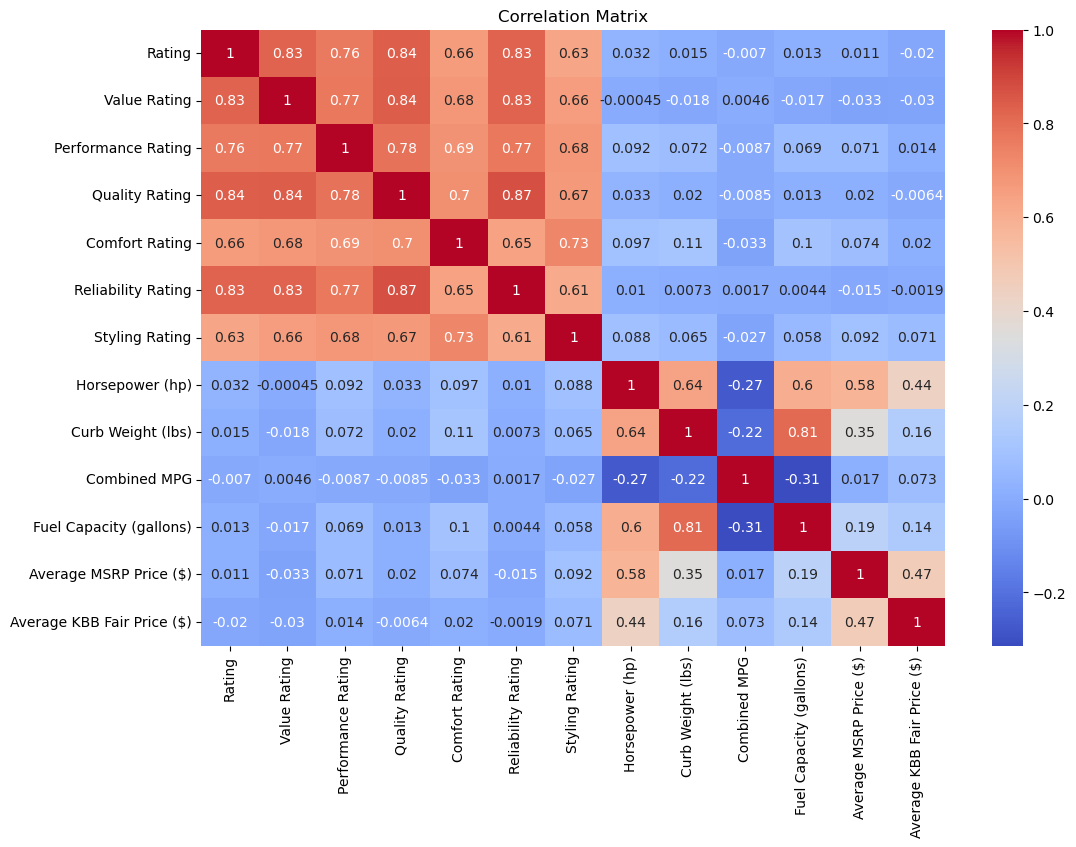

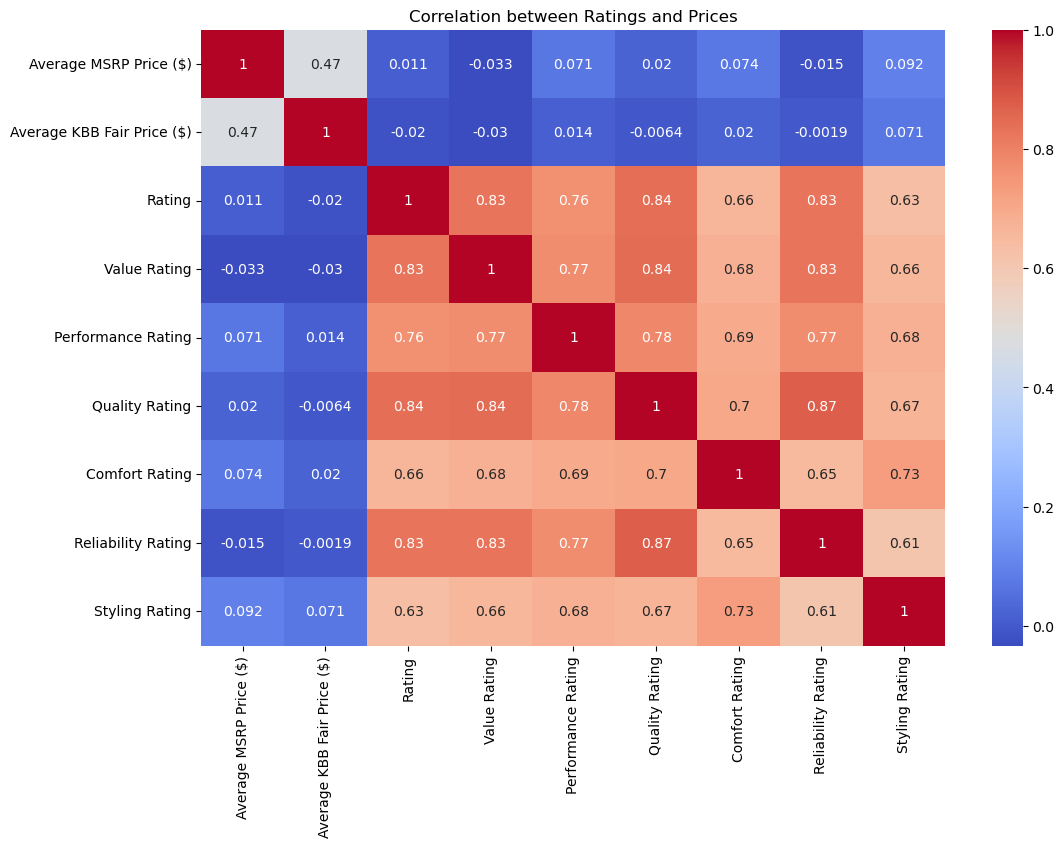

In [14]:
# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Look at correlations between ratings and prices
price_cols = ['Average MSRP Price ($)', 'Average KBB Fair Price ($)']
rating_cols = ['Rating', 'Value Rating', 'Performance Rating', 'Quality Rating',
               'Comfort Rating', 'Reliability Rating', 'Styling Rating']

# Create a subset for these columns
corr_subset = df[price_cols + rating_cols].corr()

# Visualize the subset correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm')
plt.title('Correlation between Ratings and Prices')
plt.show()

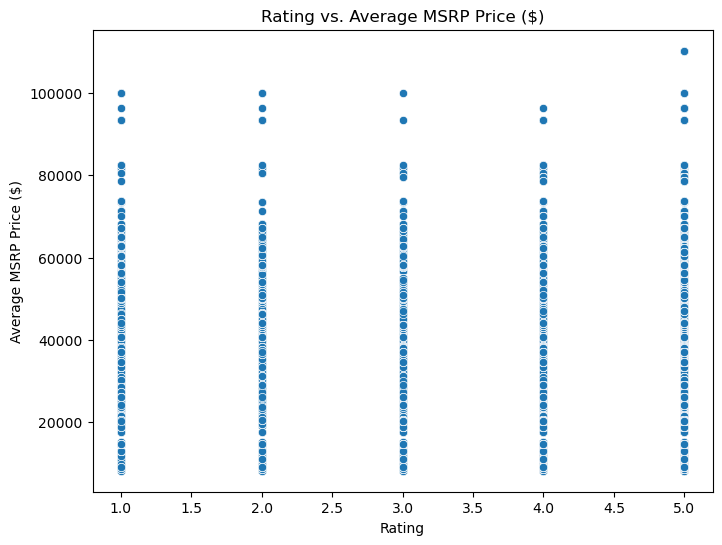

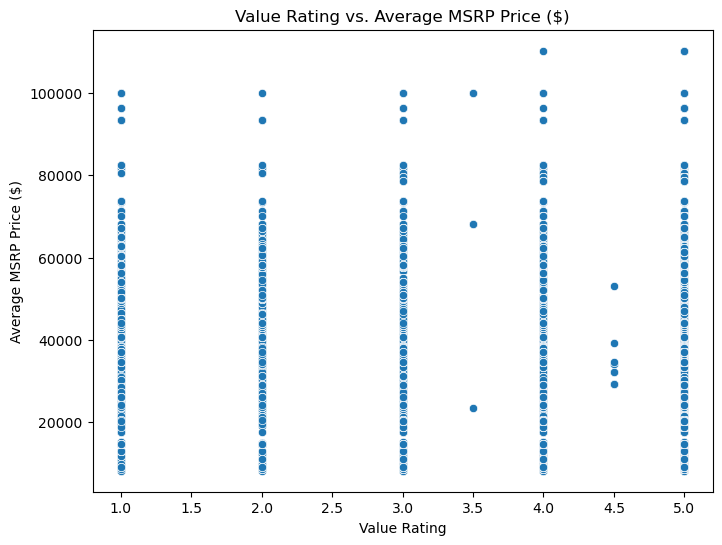

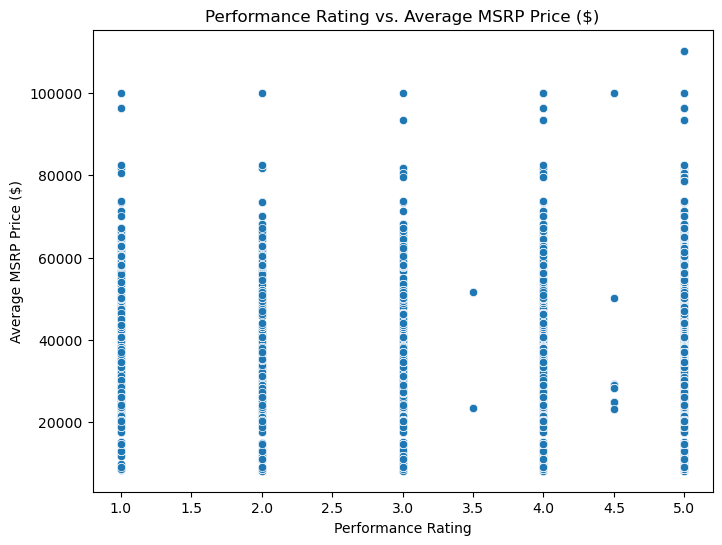

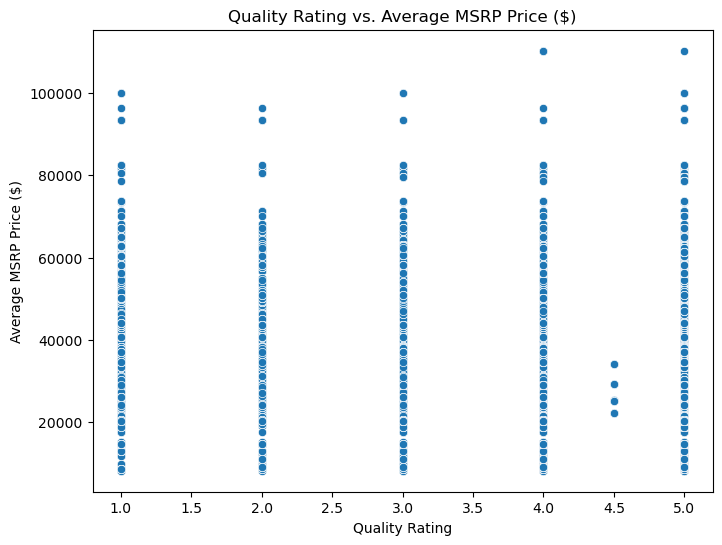

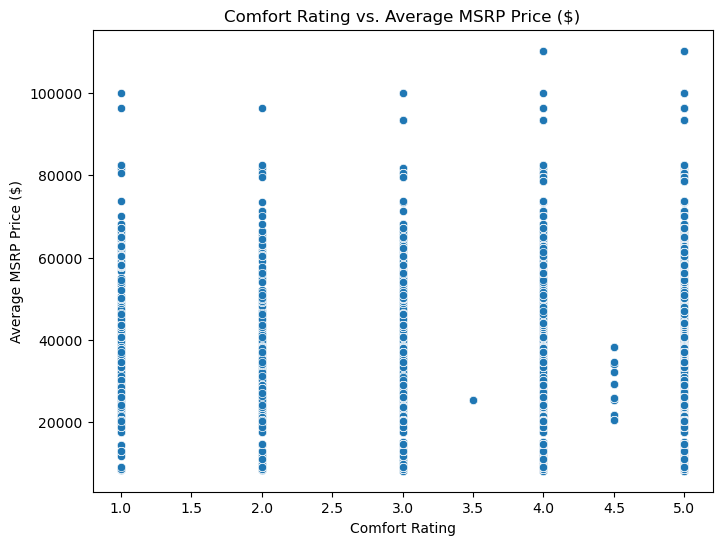

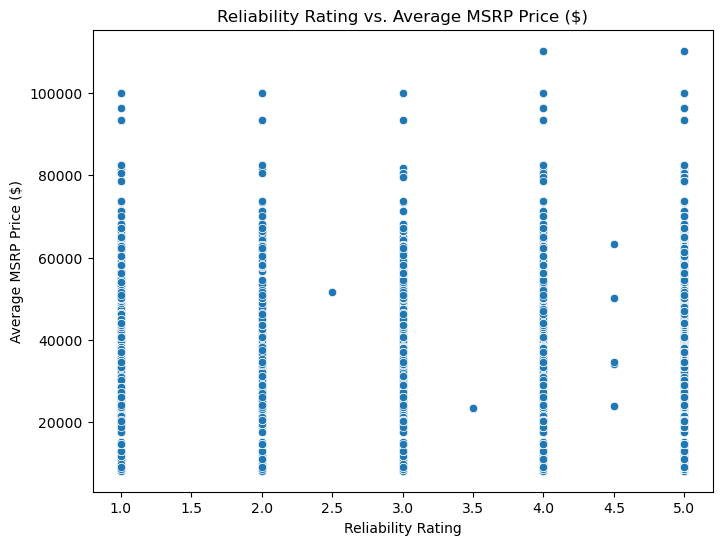

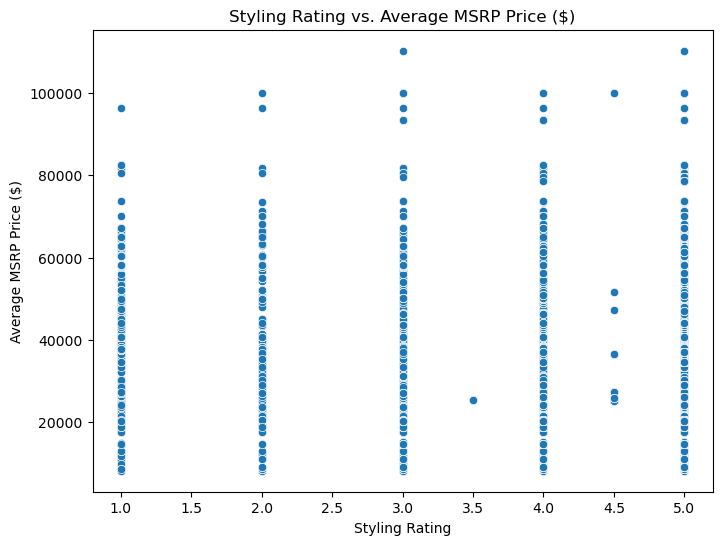

In [15]:
# Scatter plots for each rating vs. Lowest MSRP Price
for rating_col in rating_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[rating_col], y=df['Average MSRP Price ($)'])
    plt.title(f'{rating_col} vs. Average MSRP Price ($)')
    plt.xlabel(rating_col)
    plt.ylabel('Average MSRP Price ($)')
    plt.show()

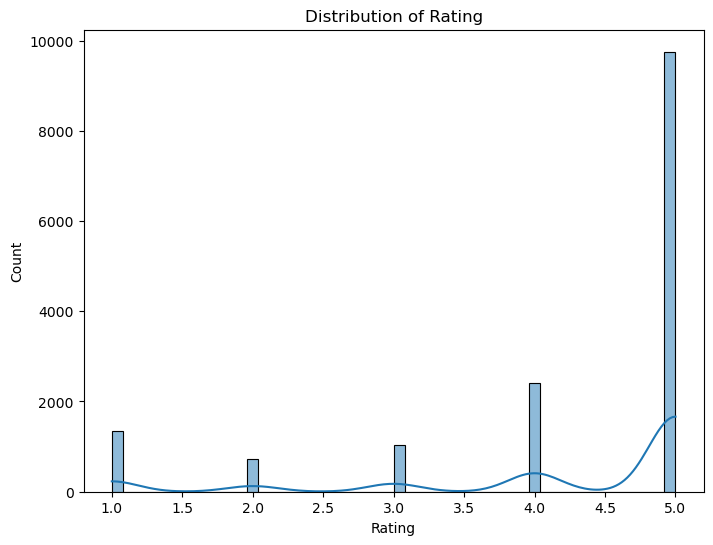

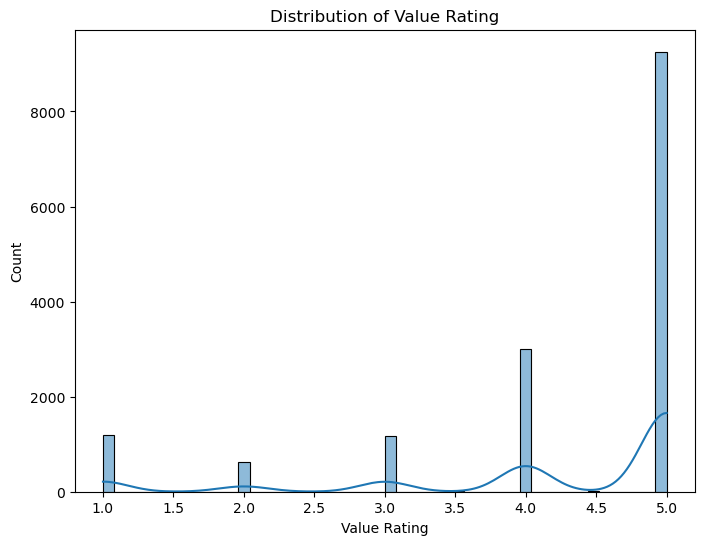

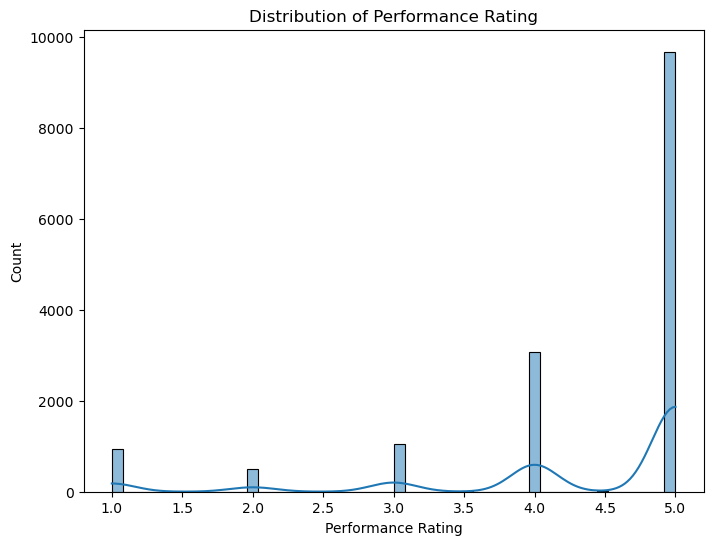

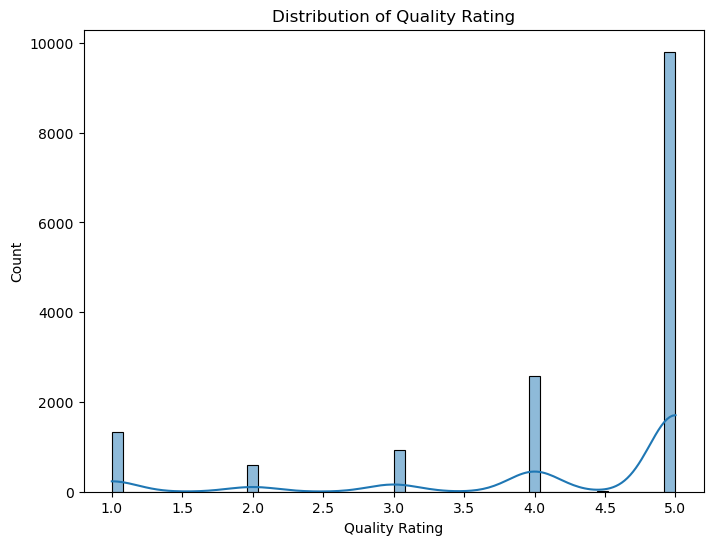

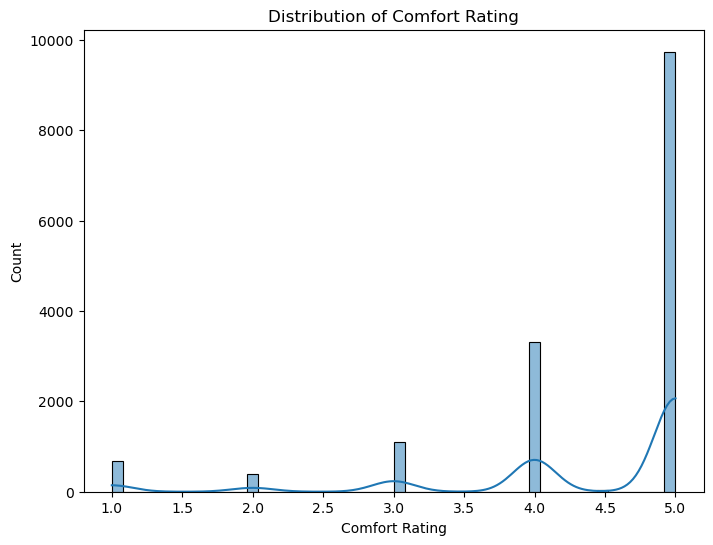

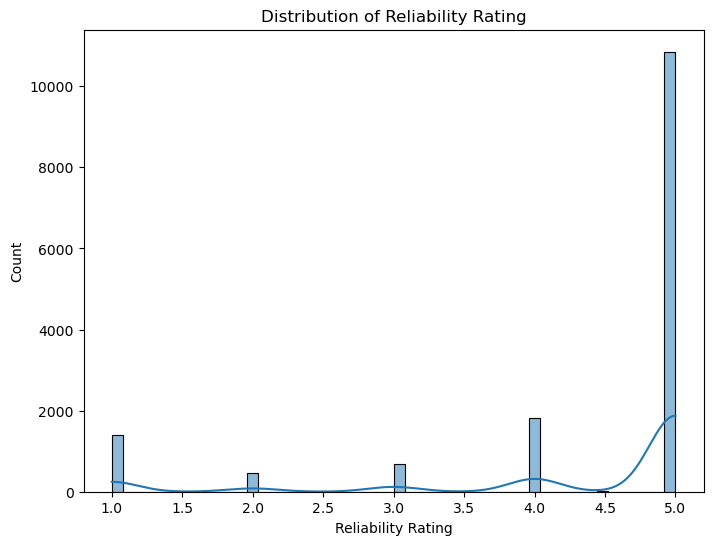

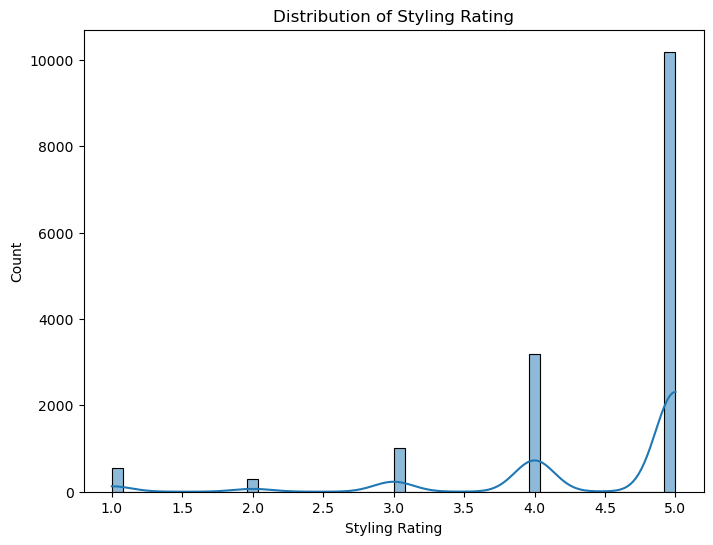

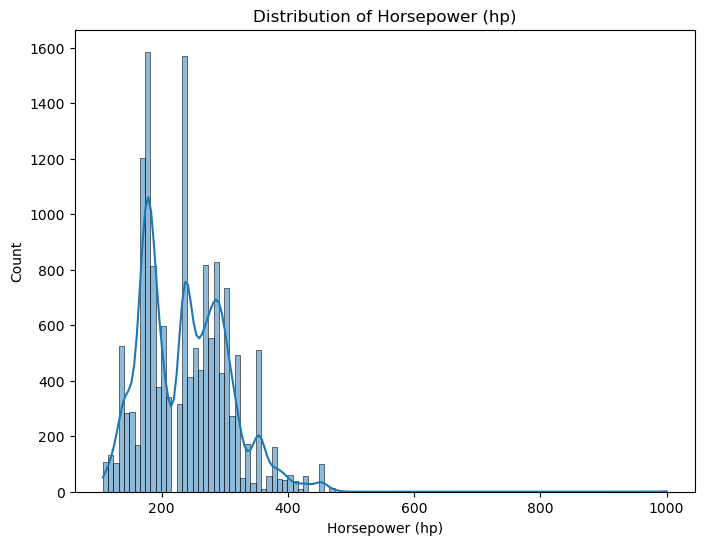

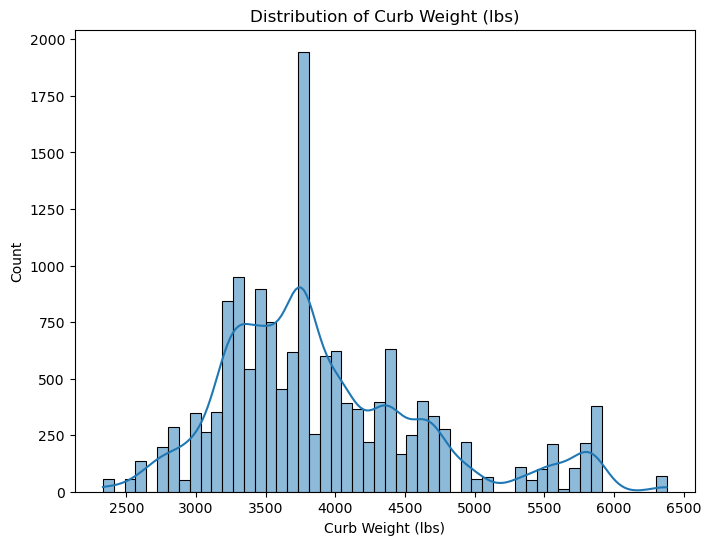

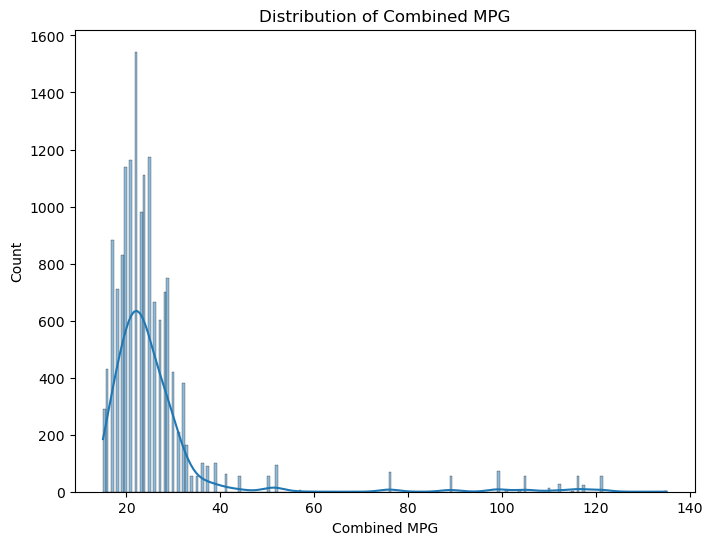

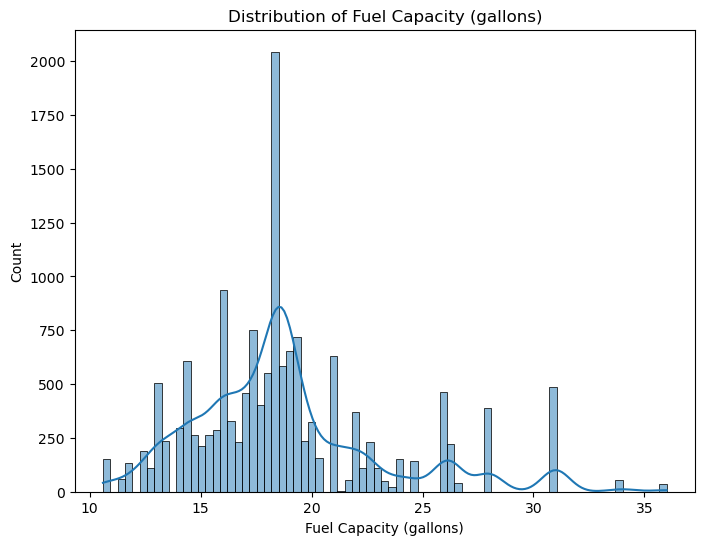

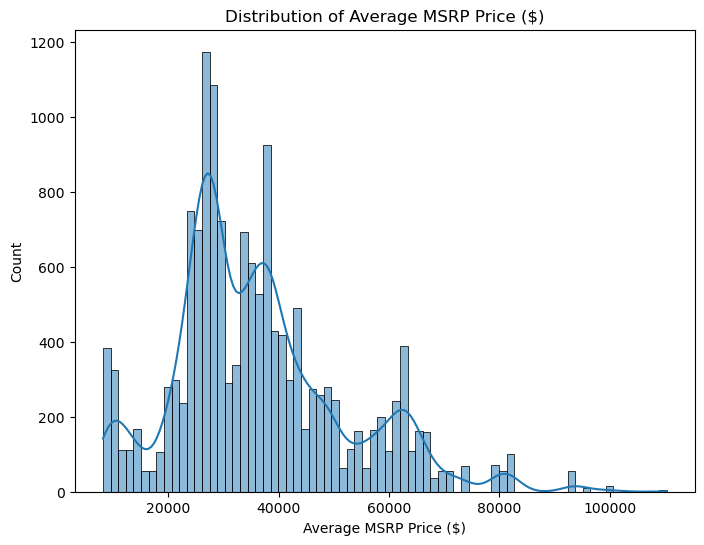

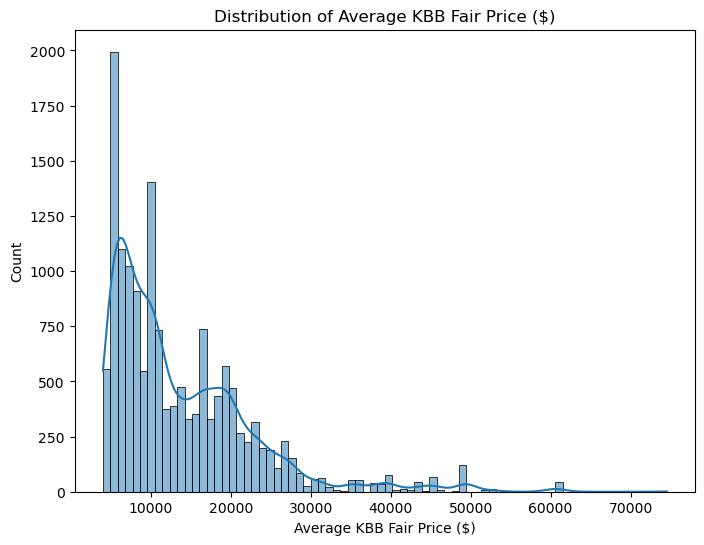

In [16]:
# Histograms for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

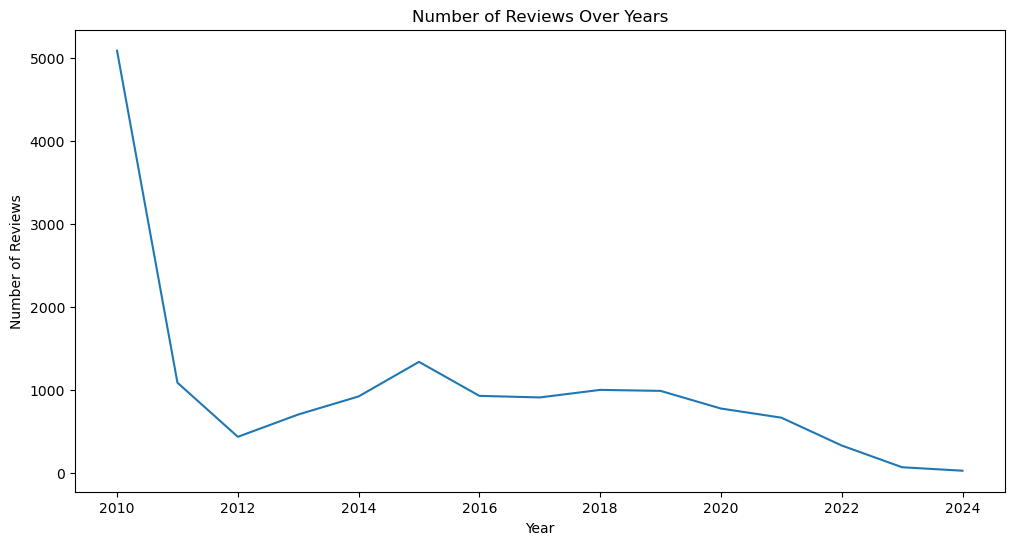

In [17]:
# Number of reviews per year
reviews_per_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=reviews_per_year.index, y=reviews_per_year.values)
plt.title('Number of Reviews Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

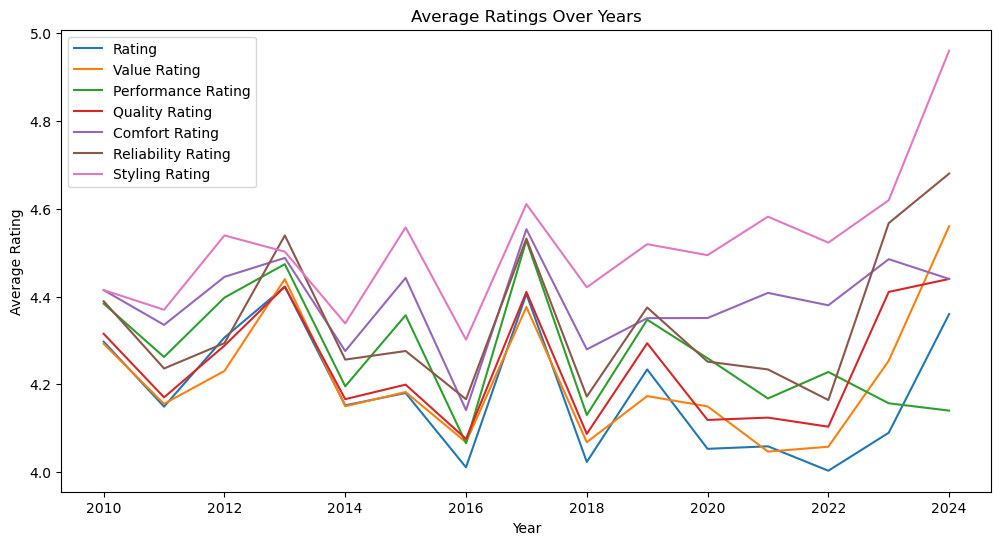

In [18]:
# Average ratings per year
average_ratings = df.groupby('Year')[rating_cols].mean()

plt.figure(figsize=(12, 6))
for col in rating_cols:
    sns.lineplot(x=average_ratings.index, y=average_ratings[col], label=col)

plt.title('Average Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

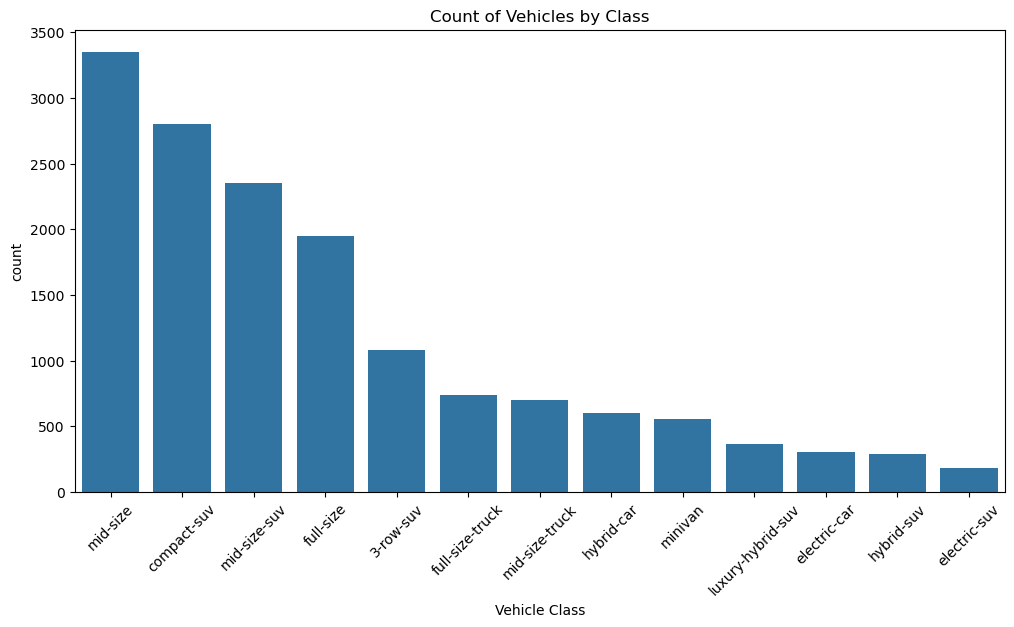

In [19]:
# Count plot for Vehicle Class
plt.figure(figsize=(12, 6))
sns.countplot(x='Vehicle Class', data=df, order=df['Vehicle Class'].value_counts().index)
plt.title('Count of Vehicles by Class')
plt.xticks(rotation=45)
plt.show()

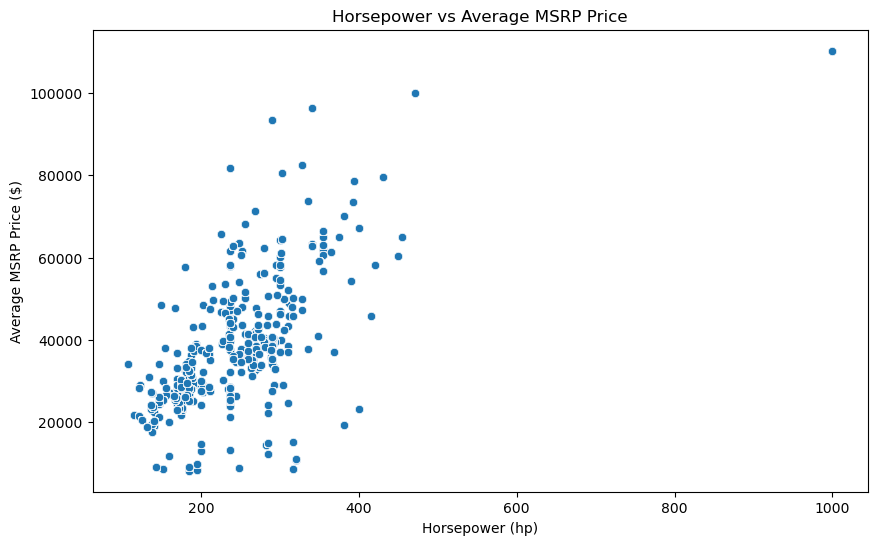

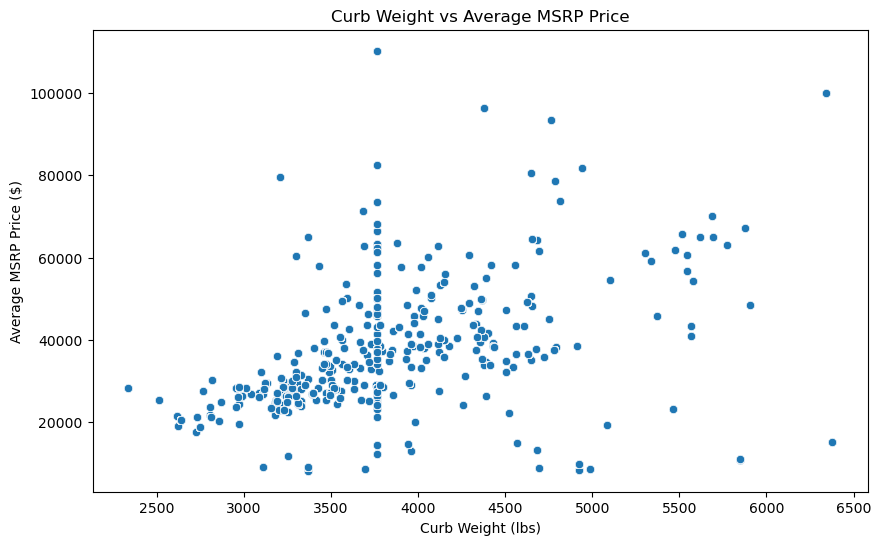

In [20]:
# Scatter plot: Horsepower vs Average MSRP Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Horsepower (hp)', y='Average MSRP Price ($)', data=df)
plt.title('Horsepower vs Average MSRP Price')
plt.show()

# Scatter plot: Curb Weight vs Average MSRP Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Curb Weight (lbs)', y='Average MSRP Price ($)', data=df)
plt.title('Curb Weight vs Average MSRP Price')
plt.show()

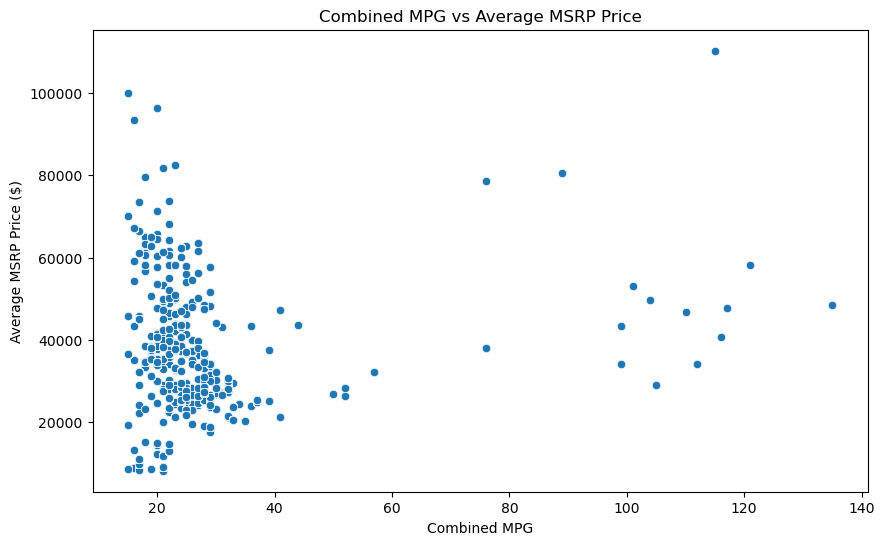

In [21]:
# Scatter plot: Combined MPG vs Average MSRP Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Combined MPG', y='Average MSRP Price ($)', data=df)
plt.title('Combined MPG vs Average MSRP Price')
plt.show()

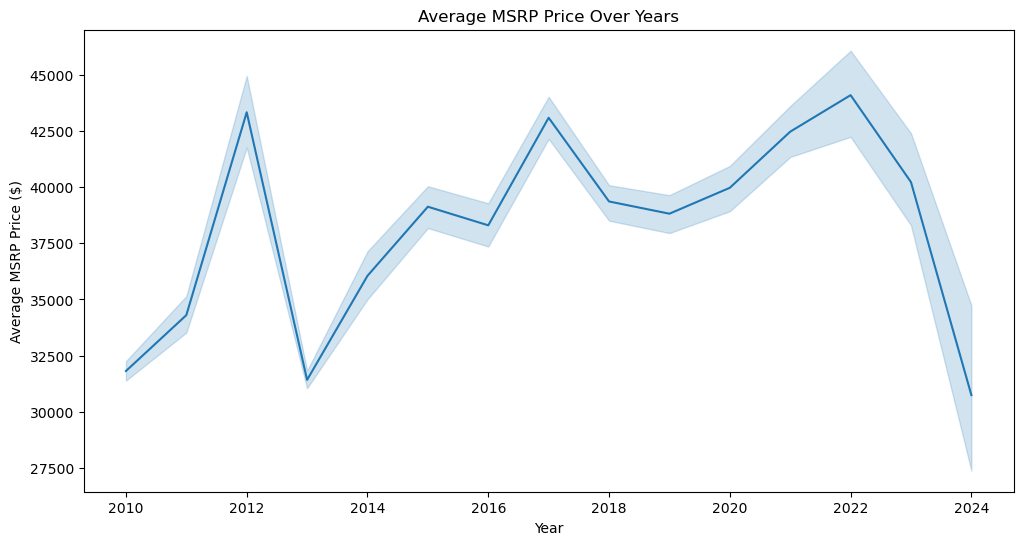

In [22]:
# Line plot: Year vs Average Average MSRP Price
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Average MSRP Price ($)', data=df, estimator='mean')
plt.title('Average MSRP Price Over Years')
plt.show()

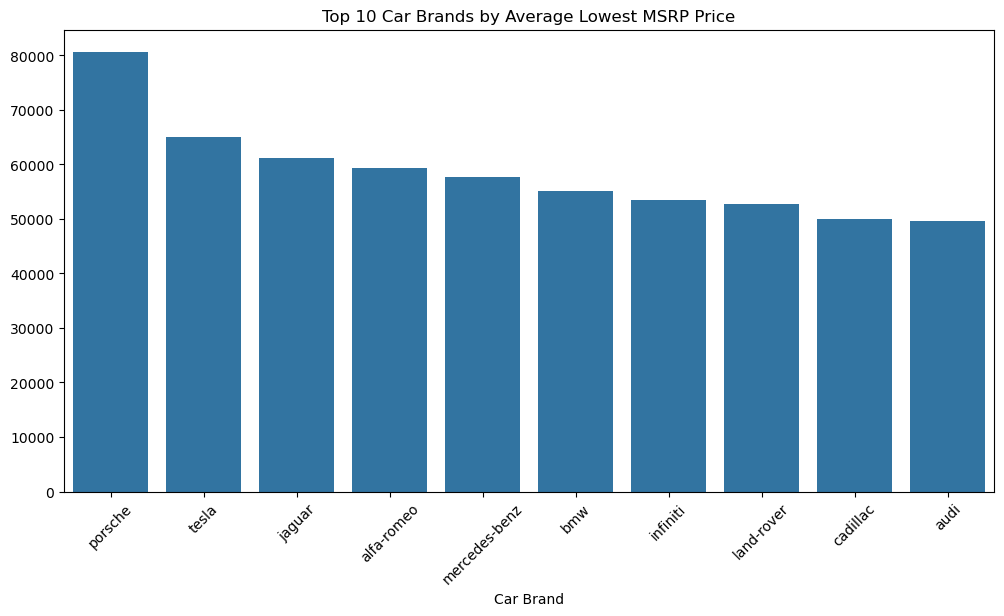

In [23]:
# Top 10 Brands by Average MSRP Price
top_brands = df.groupby('Car Brand')['Average MSRP Price ($)'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.title('Top 10 Car Brands by Average Lowest MSRP Price')
plt.xticks(rotation=45)
plt.show()

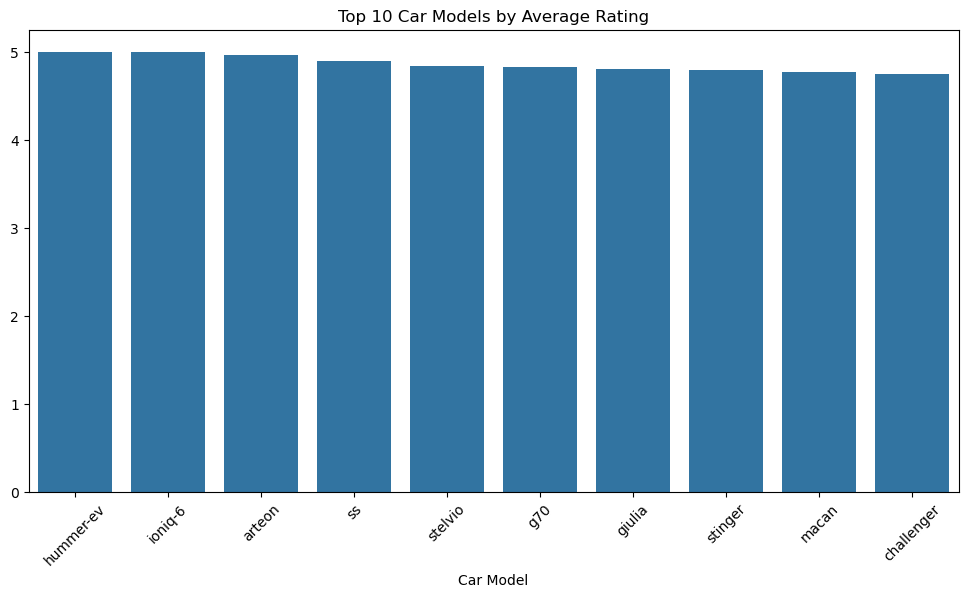

In [24]:
# Top 10 Models by Average Rating
top_models = df.groupby('Car Model')['Rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_models.index, y=top_models.values)
plt.title('Top 10 Car Models by Average Rating')
plt.xticks(rotation=45)
plt.show()

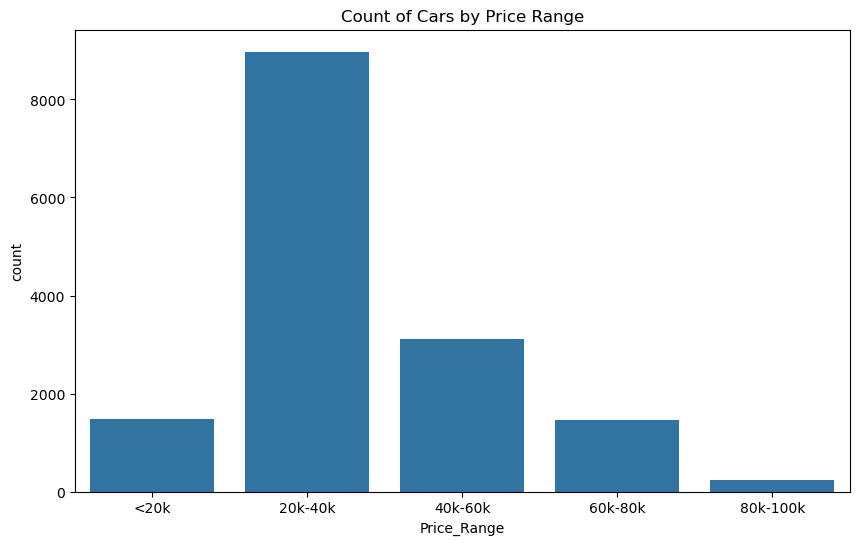

In [25]:
# Define price bins
price_bins = [0, 20000, 40000, 60000, 80000, 100000]
price_labels = ['<20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k']
df['Price_Range'] = pd.cut(df['Average MSRP Price ($)'], bins=price_bins, labels=price_labels)

# Countplot of Price Range
plt.figure(figsize=(10, 6))
sns.countplot(x='Price_Range', data=df, order=price_labels)
plt.title('Count of Cars by Price Range')
plt.show()

In [26]:
# Summary statistics for numerical columns
df[numerical_cols].describe()

,Rating,Value Rating,Performance Rating,Quality Rating,Comfort Rating,Reliability Rating,Styling Rating,Horsepower (hp),Curb Weight (lbs),Combined MPG,Fuel Capacity (gallons),Average MSRP Price ($),Average KBB Fair Price ($)
count,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000
mean,4.210682,4.215498,4.315727,4.242300,4.381979,4.326933,4.454423,237.731455,3912.006815,26.148165,18.830262,36389.487516,13698.513073
std,1.284174,1.224386,1.135456,1.259783,1.032611,1.266995,0.964796,68.810322,754.522189,14.576549,4.386694,15731.377231,9063.272773
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,107.000000,2332.000000,15.000000,10.600000,8152.000000,3996.500000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,181.000000,3366.000000,20.000000,15.900000,26305.000000,6894.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,236.000000,3761.000000,23.000000,18.500000,33944.500000,10593.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,285.000000,4336.000000,27.000000,20.000000,43505.000000,18476.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1000.000000,6378.000000,135.000000,36.000000,110295.000000,74500.000000
